# Generating protein structure graphs for use in graph convolutional neural networks

This notebook shows examples of how to generate protein structure graphs for use in graph convolutional neural networks.

Prerequisites:
- PDB file containing the structure of the protein. Rosetta homology models are fine. This repository contains PDB files for proteins we tested.

Main steps:
- Generate a matrix containing pairwise distances for all residues.
- Construct undirected graph with a node for each residue and an edge between nodes if the nodes are within the specified threshold.
- Visualize the distance matrices, contact maps with specified thresholds, and the undirected structure graphs.

In [1]:
# reload modules before executing code in order to make development and debugging easier
%load_ext autoreload
%autoreload 2

In [2]:
# this jupyter notebook is running inside of the "notebooks" directory
# for relative paths to work properly, we need to set the current working directory to the root of the project
# for imports to work properly, we need to add the code folder to the system path
import os
from os.path import abspath, join, isdir
import sys
if not isdir("notebooks"):
    # if there's a "notebooks" directory in the cwd, we've already set the cwd so no need to do it again
    os.chdir("..")
module_path = abspath("code")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
    
import gen_structure_graph as gsg
import constants
import utils

# Residue distance matrix using C$\beta$ distances


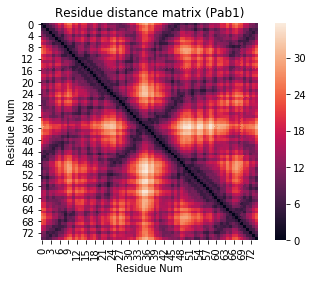

In [4]:
# calculate the residue distance matrix
pdb_fn = "data/pab1/pab1_rosetta_model.pdb"
dist_mtx = gsg.cbeta_distance_matrix(pdb_fn)

fig, ax = plt.subplots(1)
ax = sns.heatmap(dist_mtx, ax=ax, square=True)
ax.set(xlabel="Residue Num", ylabel="Residue Num", title="Residue distance matrix (Pab1)")
plt.show()
plt.close(fig)

A histogram of distances might give insights into a good contact threshold. Note that we ultimately determined the threshold for each dataset using a hyperparameter sweep. 

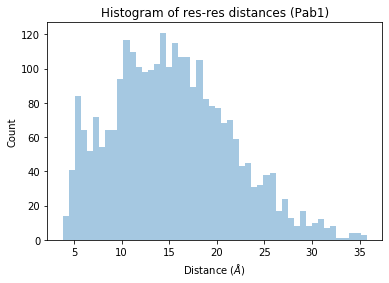

In [5]:
mask = np.triu(np.ones_like(dist_mtx, dtype=np.bool), 1)
all_distances = dist_mtx[mask]
fig, ax = plt.subplots(1)
ax = sns.distplot(all_distances, bins=50, hist=True, kde=False, ax=ax)
ax.set(xlabel="Distance ($\AA$)", ylabel="Count", title="Histogram of res-res distances (Pab1)")
plt.show()
plt.close(fig)

# Contact maps with a specified distance threshold

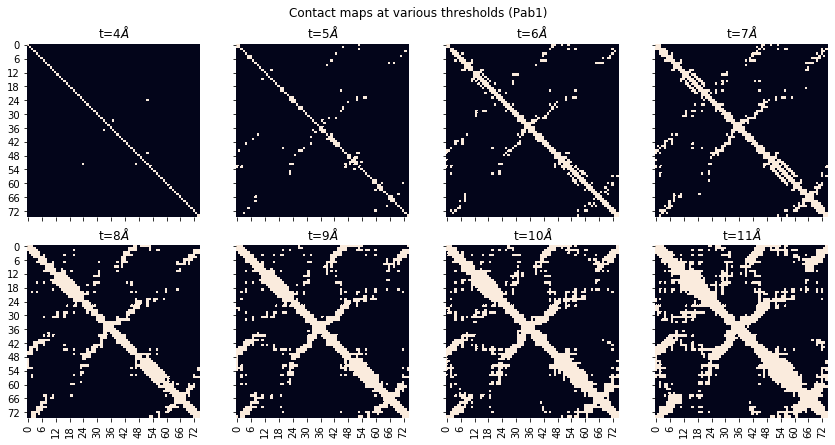

In [43]:
# Visualize the contact maps at various thresholds
thresholds = [4, 5, 6, 7, 8, 9, 10, 11]
fig, axes = plt.subplots(nrows=2, ncols=4, squeeze=True, sharey=True, sharex=True, figsize=(12, 6))
axes = axes.flatten()
for i, t in enumerate(thresholds):
    ax = axes[i]
    ax = sns.heatmap(np.where(dist_mtx < t, 1, 0), square=True, cbar=False, ax=ax)
    ax.set(title="t={}$\AA$".format(t))
fig.suptitle("Contact maps at various thresholds (Pab1)", y=1.02)
plt.tight_layout()
plt.show()
plt.close(fig)

# Structure graphs
A structure graph can be genereated from a residue distance matrix using the function `gsg.dist_thresh_graph()` or `gsg.gen_graph()`.

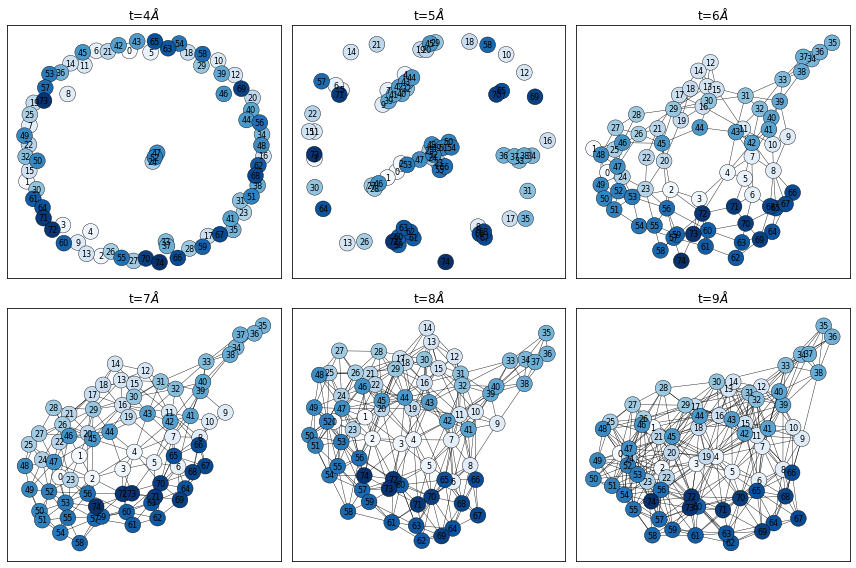

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()
thresholds = [4, 5, 6, 7, 8, 9]
for i, t in enumerate(thresholds):
    ax = axes[i]
    g = gsg.dist_thresh_graph(dist_mtx, t)
    node_values = [node + 1 for node in g.nodes()]
    node_layout = nx.spring_layout(g, seed=1)
    nx.draw(g, cmap=plt.get_cmap("Blues"), with_labels=True, node_color=node_values, font_size=8,
            node_size=250, edgecolors="black",  width=0.4, linewidths=0.4, pos=node_layout, ax=ax)
    ax.set(title="t={}$\AA$".format(t))
    ax.axis("on")
plt.tight_layout()
plt.show()
plt.close(fig)

# Baseline graphs
There is support for generating a variety of baseline graphs using `gsg.gen_graph()`.

In [63]:
print([e.name for e in gsg.GraphType])

['LINEAR', 'COMPLETE', 'DISCONNECTED', 'DIST_THRESH', 'DIST_THRESH_SHUFFLED']


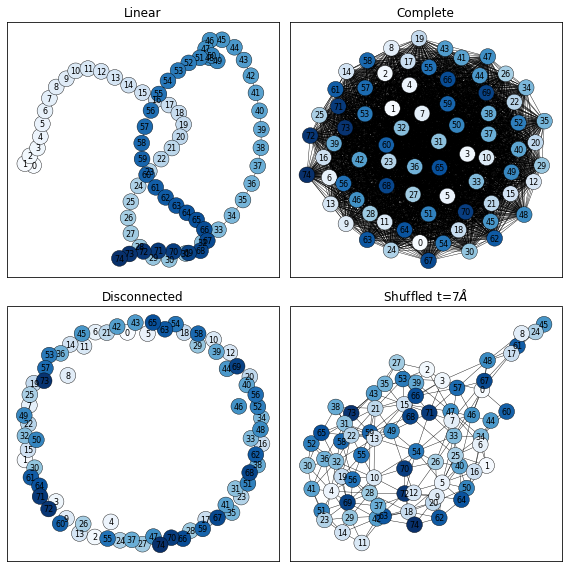

In [69]:
g_lin = gsg.gen_graph(gsg.GraphType.LINEAR, dist_mtx)
g_com = gsg.gen_graph(gsg.GraphType.COMPLETE, dist_mtx)
g_dis = gsg.gen_graph(gsg.GraphType.DISCONNECTED, dist_mtx)
g_shuff = gsg.gen_graph(gsg.GraphType.DIST_THRESH_SHUFFLED, dist_mtx, dist_thresh=7, shuffle_seed=1)
graphs = [g_lin, g_com, g_dis, g_shuff]
names = ["Linear", "Complete", "Disconnected", "Shuffled t=7$\AA$"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes = axes.flatten()
for i, (g, name) in enumerate(zip(graphs, names)):
    ax = axes[i]
    node_values = [node + 1 for node in g.nodes()]
    node_layout = nx.spring_layout(g, seed=1)
    nx.draw(g, cmap=plt.get_cmap("Blues"), with_labels=True, node_color=node_values, font_size=8,
            node_size=250, edgecolors="black",  width=0.4, linewidths=0.4, pos=node_layout, ax=ax)
    ax.set(title=name)
    ax.axis("on")
plt.tight_layout()
plt.show()
plt.close(fig)

# Adjacency matrix
The adjacency matrix is used in the graph convolution implementation.

In [79]:
g = gsg.gen_graph(gsg.GraphType.DIST_THRESH, dist_mtx, dist_thresh=7)
gsg.ordered_adjacency_matrix(g)

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.]], dtype=float32)